# Data science capstone project:



## - Classifying whether a food place is "satisfactory" or "not satisfactory" in Stockholm county

_________________

### Business problem

Being mildly disappointed after trying a new restaurant is quite a common experience in Stockholm county.

It would therefore be beneficial for customers to get some guidance as to whether a restaurant in Stockholm county is worth trying based on a few immediately visible attributes which are easy to input by a user.

**Question: Can we classify whether a food place in Stockholm county is going to be "satisfactory" or "not satisfactory" before ordering in it?**
________________________

### Analytical approach

Since "satisfactory" vs "not satisfactory" is a fuzzy binary classifier it seems most appropriate to use a Bayesian approach and get probabilities for each of the two outcomes.

We therefore choose **logistic regression** as our analytical model

___________________________________

### Data requirements

To understand how favourably a restaurant is regarded we need data quantifying customer sentiments, for example through **ratings**.

As an objective measure of whether a restaurant is "satisfactory" or "not satisfactory" we use the **average rating as a threshold**. 

If the rating is above average then we say that the food place is "satisfactory" and otherwise "not satisfactory".

We would naturally expect that the **type of food place** plays a role in determining the rating. 

The **priciness** of the food place may presumably also be determining factor.

Both of these criteria are readily visible when visiting the food place, so they can easily be inputted to the model (which is a business requirement).
________________________________

### Data collection

##### 1.  Read postcodes from spreadsheet provided by Statistiska Centralbyrån (SCB) and filter for postcodes in Stockholm county (postcodes starting with '1') 

##### 2.  Use 'Here' API to retrieve geolocations for each postcode

##### 3.  Use 'Foursquare' API to explore venues around each geolocation and filter for restaurants

##### 4.  Use 'Foursquare' API to get rating and price tier for each restaurant


Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

Read postcodes from spreadsheet provided by Statistiska Centralbyrån (SCB) and filter for postcodes in Stockholms län (postcodes starting with '1') 

In [2]:
df_postcodes = pd.read_excel('Totalbef_postnr.xls', header=[17])

df_postcodes.columns = ["Postcode", "City", "Population"]

df_postcodes['Postcode'] = df_postcodes['Postcode'].astype(str)

df_postcodes = df_postcodes[df_postcodes["Postcode"].str.startswith('1', na = False)]

df_postcodes.head()

,Postcode,City,Population
1,11115,STOCKHOLM,4
2,11120,STOCKHOLM,159
3,11121,STOCKHOLM,274
4,11122,STOCKHOLM,135
5,11123,STOCKHOLM,765


In [3]:
df_postcodes.shape

(1880, 3)

##### Use 'Here' API to retrieve geolocations for each postcode

In [ ]:
!conda install -c conda-forge geopy --yes

In [36]:
from geopy.geocoders import Nominatim
from geopy.geocoders import Here
from geopy.extra.rate_limiter import RateLimiter


from tqdm import tqdm
tqdm.pandas()

def get_lat_lng_for_postcode_city(geocoder, postcode, city):
    location = geocoder({"country": "SE", "city":city, "postalcode":str(postcode)})
    if location != None : return tuple(location.point)
    return None

In [ ]:
geolocator = Here("<app_id>","<app_code>")   #create an account at https://developer.here.com/ to retrieve api_key and api_code
geocoder = RateLimiter(geolocator.geocode)
df_geolocations = df_postcodes
df_geolocations["Location"] = df_geolocations.progress_apply(lambda row: get_lat_lng_for_postcode_city(geocoder, row['Postcode'], row['City']), axis=1)

In [ ]:
# Persist geolocation data so that we don't have to call the API every time
writer = pd.ExcelWriter("<filename>.xlsx") 
df_geolocations.to_excel(writer)
writer.save()

Read persisted Stockholm county geolocations from excel file into data frame and reformat.

Drop non-existent geolocations.

In [3]:
df_geolocations = pd.read_excel('geolocations.xlsx',  na_values=['nan'], keep_default_na=False)

def split_location(location, idx):
    if location == '' : return None
    return str(location)[1:-1].split(",")[idx]

df_geolocations["Latitude"] = df_geolocations.apply(lambda row: split_location(row['Location'], 0), axis=1)
df_geolocations["Latitude"] = df_geolocations["Latitude"].astype('float')

df_geolocations["Longitude"] = df_geolocations.apply(lambda row: split_location(row['Location'], 1), axis=1)
df_geolocations["Longitude"] = df_geolocations["Longitude"].astype('float')

df_geolocations.dropna(inplace = True)

df_geolocations.drop(columns = ["Location"], inplace=True)

df_geolocations.shape

(1818, 5)

##### Use 'Foursquare' API to explore venues around each geolocation and filter for restaurants on venue category

In [4]:
import json
import requests
from pandas.io.json import json_normalize

In [1]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20181114' # Foursquare API version

Helper function for appending to excel file - we use it because the Foursquare API hangs when querying all Venue IDs, so we save incrementally and resume query

In [6]:
def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False, 
                       **to_excel_kwargs):
    
    from openpyxl import load_workbook

    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl')

    # Python 2.x: define [FileNotFoundError] exception if it doesn't exist 
    try:
        FileNotFoundError
    except NameError:
        FileNotFoundError = IOError


    try:
        # try to open an existing workbook
        writer.book = load_workbook(filename)

        # get the last row in the existing Excel sheet
        # if it was not specified explicitly
        if startrow is None and sheet_name in writer.book.sheetnames:
            startrow = writer.book[sheet_name].max_row

        # truncate sheet
        if truncate_sheet and sheet_name in writer.book.sheetnames:
            # index of [sheet_name] sheet
            idx = writer.book.sheetnames.index(sheet_name)
            # remove [sheet_name]
            writer.book.remove(writer.book.worksheets[idx])
            # create an empty sheet [sheet_name] using old index
            writer.book.create_sheet(sheet_name, idx)

        # copy existing sheets
        writer.sheets = {ws.title:ws for ws in writer.book.worksheets}
    except FileNotFoundError:
        # file does not exist yet, we will create it
        pass

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, header = False, **to_excel_kwargs)

    # save the workbook
    writer.save()

Function for exploring nearby venues of a geocoordinate

In [25]:
def getNearbyVenues(postcodes, latitudes, longitudes, radius=500, LIMIT=100):
    venues_list=[]
    count = 0
    for postcode, lat, lng in zip(postcodes, latitudes, longitudes):
        print(postcode)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']["id"] ) for v in results])
        
        count = count + len(results)
        if count > 1000:
                nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
                nearby_venues.columns = ['Postcode',
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID'          ]
               
                append_df_to_excel("venuedata.xlsx", nearby_venues)
                venues_list = []
                count = 0
                
    print("done!")

Get venues (max 100) within a 500 meter radius from each geocoordinate using Foursquare API

In [ ]:
df_geo = df_geolocations #[df_geolocations['Postcode'].astype('int') > 19740]

getNearbyVenues(postcodes=df_geo['Postcode'],
                                        latitudes=df_geo['Latitude'],
                                        longitudes=df_geo['Longitude']
                )



Read raw venue information, drop redundant information, join with City information and resave table.

In [5]:
df_venues = pd.read_excel('venuedata.xlsx',  na_values=['nan'], keep_default_na=False, header=None)
df_venues.drop(columns = [0], inplace=True)
df_venues.columns = ['Postcode', 'Latitude', 'Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Venue ID']
df_restaurants = df_venues.set_index('Venue Category').filter(regex='Restaurant|Pizza|Taco|Burger|Gastro|Noodle|Steak', axis=0).reset_index()
df_restaurants['Postcode'] = df_restaurants['Postcode'].astype(str)

df_restaurant_city = df_postcodes.join(df_restaurants.set_index('Postcode'), on='Postcode', how = 'inner').reset_index()

#df_restaurant_city = df_restaurant_city[['Venue ID', 'Venue Category', 'City']]

df_restaurant_city = df_restaurant_city.drop_duplicates(subset = ["Venue ID"])


df_restaurant_city.head()

#writer = pd.ExcelWriter("restaurant_city.xlsx")
#df_restaurant_city.to_excel(writer)
#writer.save()

,index,Postcode,City,Population,Venue Category,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID
0,1,11115,STOCKHOLM,4,Szechuan Restaurant,59.33913,18.06768,Surfers Stockholm,59.338580,18.067412,5491ccf5498ee346e18b6a76
1,1,11115,STOCKHOLM,4,Steakhouse,59.33913,18.06768,Vassa Eggen Restaurant,59.337573,18.069548,4adcdaf0f964a520535b21e3
2,1,11115,STOCKHOLM,4,Modern European Restaurant,59.33913,18.06768,Doktor Mat,59.340670,18.064492,573eda6f498eff71f2749af4
3,1,11115,STOCKHOLM,4,Eastern European Restaurant,59.33913,18.06768,Bar Central,59.339200,18.068003,54f04f99498e311c661d5966
4,1,11115,STOCKHOLM,4,Asian Restaurant,59.33913,18.06768,Ingers Kitchen,59.337224,18.067062,53e7a0f3498e8e59724e4b9c


##### Use 'Foursquare' API to get rating and price tier for each restaurant

In [20]:
def persistRestaurantInformation(venue_ids, start):
        total_count = start
        venue_ids = venue_ids[start:]
        counter = 0
        info_list = []
        
        for venue_id in venue_ids:
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
            
            print(url)
            # make the GET request
            result = requests.get(url).json()
        
            # get price tier and rating information
            price_tier = None
            try:
                price_tier = result['response']['venue']['price']['tier']
            except KeyError:
                price_tier = None
        
            rating = None
            try:
                rating = result['response']['venue']['rating']
            except KeyError:
                rating = None
                
            info_list.append([(venue_id, price_tier, rating)])        
            
            counter = counter + 1
            total_count = total_count + 1
            print(total_count,  price_tier, rating)
            
            if counter >= 500:
                print("*********WRITING**********")
                df_info_list = pd.DataFrame([item for info_list in info_list for item in info_list])
                df_info_list.columns = ['Venue ID','Price Tier','Rating']
                append_df_to_excel("restaurantinfo.xlsx", df_info_list)
                info_list = []
                counter = 0
                return
            

In [ ]:
persistRestaurantInformation(df_null_venues['Venue ID'], 0)   # We make premium calls here in the Foursquare API (limit is 500/day)

Remove duplicate venues and join rating and price tier information with venue category and city information

In [7]:
df_restaurant_info = pd.read_excel('restaurantinfo.xlsx', header=None)
df_restaurant_info.drop(columns = [0], inplace=True)
df_restaurant_info.columns = ['Venue ID', 'Price Tier', 'Rating']
df_restaurant_info_nodups = df_restaurant_info.drop_duplicates(subset = ["Venue ID"])

df_restaurant_city =  pd.read_excel('restaurant_city.xlsx')

df_restaurant_city_price_rating = df_restaurant_city.join(df_restaurant_info_nodups.set_index('Venue ID'), on='Venue ID', how = 'left').reset_index()

df_restaurant_city_price_rating.head()

,index,Venue ID,Venue Category,City,Price Tier,Rating
0,0,5491ccf5498ee346e18b6a76,Szechuan Restaurant,STOCKHOLM,NaN,8.9
1,1,4adcdaf0f964a520535b21e3,Steakhouse,STOCKHOLM,4.0,8.3
2,2,573eda6f498eff71f2749af4,Modern European Restaurant,STOCKHOLM,NaN,8.6
3,3,54f04f99498e311c661d5966,Eastern European Restaurant,STOCKHOLM,2.0,8.0
4,4,53e7a0f3498e8e59724e4b9c,Asian Restaurant,STOCKHOLM,2.0,7.9


_________________

## Data understanding and preparation

In [8]:
df_mean_rating = df_restaurant_city_price_rating.groupby(["City"]).mean()

df_sorted_mean_rating = df_mean_rating.sort_values(["Rating"], axis=0, ascending=False, kind='quicksort', na_position='last').reset_index()

df_mean_ranking = df_sorted_mean_rating[["City", "Rating"]]

df_mean_ranking.columns = ["City", "Mean Rating"]

df_mean_ranking.head(45)

,City,Mean Rating
0,NACKA STRAND,7.500000
1,DANDERYD,7.500000
2,STOCKHOLM,7.479939
3,SIGTUNA,7.450000
4,ÅRSTA,7.400000
5,DJURSHOLM,7.200000
6,ENSKEDEDALEN,7.142857
7,VALLENTUNA,7.100000
8,SPÅNGA,7.100000
9,SKARPNÄCK,7.100000


Analyzing the average rating per city in Stockholm county we see that it is significantly higher in Stockholm city than in other cities in Stockholm county (perhaps this is due to higher competition and survival bias?)

Note that the cities with higher rating than Stockholm city have too few samples to draw any accurate conclusions.

Thus we introduce a binary feature indicating whether the restaurant belongs to Stockholm city or not as this is likely to affect the rating.

In [9]:
df_restaurant_city_price_rating["City"] = df_restaurant_city_price_rating["City"].str.replace(" ","")

df_restaurant_city_price_rating["In Stockholm City"] = df_restaurant_city_price_rating.apply(lambda row: int(row["City"] == "STOCKHOLM"), axis = 1)

df_restaurant_city_price_rating.head()

,index,Venue ID,Venue Category,City,Price Tier,Rating,In Stockholm City
0,0,5491ccf5498ee346e18b6a76,Szechuan Restaurant,STOCKHOLM,NaN,8.9,1
1,1,4adcdaf0f964a520535b21e3,Steakhouse,STOCKHOLM,4.0,8.3,1
2,2,573eda6f498eff71f2749af4,Modern European Restaurant,STOCKHOLM,NaN,8.6,1
3,3,54f04f99498e311c661d5966,Eastern European Restaurant,STOCKHOLM,2.0,8.0,1
4,4,53e7a0f3498e8e59724e4b9c,Asian Restaurant,STOCKHOLM,2.0,7.9,1


Check which venue categories are most common

In [10]:
df_venue_counts = df_restaurant_city_price_rating.groupby(['Venue Category']).count().reset_index()

df_venue_counts = df_venue_counts.sort_values(by=['Venue ID'], ascending = False)

df_venue_counts = df_venue_counts[["Venue Category", "Venue ID"]]

df_venue_counts.columns = ["Venue Category", "Count"] 

df_venue_counts.shape

(62, 2)

To reduce the number of features we include only the most common venue categories

In [16]:
df_restaurant_city_price_rating = df_restaurant_city_price_rating[~df_restaurant_city_price_rating["Rating"].isnull()]

venue_categories = ['In Stockholm City', 'Price Tier', 'Restaurant', 'Asian Restaurant', 'Scandinavian Restaurant', 'Burger Joint', 'Fast Food Restaurant', 
        'Sushi Restaurant', 'Thai Restaurant', 'Pizza Place','Italian Restaurant', 'Indian Restaurant', 'American Restaurant', 
        'Chinese Restaurant', 'Middle Eastern Restaurant', 'French Restaurant', 'Greek Restaurant', 'Japanese Restaurant', 'Steakhouse', 
        'Seafood Restaurant', 'Kebab Restaurant'            
        ]

df_restaurant_city_price_rating = df_restaurant_city_price_rating[df_restaurant_city_price_rating["Venue Category"].isin(venue_categories)]

df_restaurant_city_price_rating.head()





,index,Venue ID,Venue Category,City,Price Tier,Rating,In Stockholm City
1,1,4adcdaf0f964a520535b21e3,Steakhouse,STOCKHOLM,4.0,8.3,1
4,4,53e7a0f3498e8e59724e4b9c,Asian Restaurant,STOCKHOLM,2.0,7.9,1
5,5,57c40aed498ed728e183fdc1,Scandinavian Restaurant,STOCKHOLM,2.0,8.4,1
8,8,4ba12396f964a520999b37e3,Steakhouse,STOCKHOLM,4.0,8.0,1
9,9,51041df0e4b073eb96e6d58e,Asian Restaurant,STOCKHOLM,2.0,9.3,1


Calculate the mean rating among all restaurants for use as threshold

In [17]:
mean_rating = df_restaurant_city_price_rating["Rating"].mean()
mean_rating

7.164276729559743

Classify each restaurant as "satisfactory" (1) or "not satisfactory" (0) based on comparison with mean rating.

In [18]:
df_restaurant_city_price_rating["Verdict"] = df_restaurant_city_price_rating.apply(lambda row: row["Rating"] > mean_rating, axis = 1)

Transform the data set using one hot encoding on venue categories.

In [19]:
# one hot encoding
venue_category_onehot = pd.get_dummies(df_restaurant_city_price_rating[['Venue Category']], prefix="", prefix_sep="")
city_onehot = pd.get_dummies(df_restaurant_city_price_rating[['City']], prefix="", prefix_sep="")

# add venue id column back to dataframe
venue_category_onehot['Venue ID'] = df_restaurant_city_price_rating['Venue ID'] 


venue_category_city_onehot = venue_category_onehot

# add price tier, rating, verdict and in Stockholm city columns back to dataframe
venue_category_city_onehot['Price Tier'] = df_restaurant_city_price_rating['Price Tier'] 

venue_category_city_onehot['Price Tier'].fillna(round(venue_category_city_onehot['Price Tier'].mean()), inplace=True)

venue_category_city_onehot['Price Tier'] = venue_category_city_onehot['Price Tier'].astype('int')

venue_category_city_onehot['Rating'] = df_restaurant_city_price_rating['Rating'] 

venue_category_city_onehot['Verdict'] = df_restaurant_city_price_rating['Verdict']

venue_category_city_onehot['In Stockholm City'] = df_restaurant_city_price_rating['In Stockholm City']

venue_category_city_onehot.dropna(inplace = True)

# put venue id as first column 
cols = venue_category_city_onehot.columns.tolist()
for x in ['Venue ID', 'Rating', 'Price Tier']:
    cols.remove(x)

cols = ['Venue ID', 'Rating', 'Price Tier'] + cols
venue_category_city_onehot = venue_category_city_onehot[cols]

venue_category_city_onehot.head()


,Venue ID,Rating,Price Tier,American Restaurant,Asian Restaurant,Burger Joint,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,...,Middle Eastern Restaurant,Pizza Place,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Steakhouse,Sushi Restaurant,Thai Restaurant,Verdict,In Stockholm City
1,4adcdaf0f964a520535b21e3,8.3,4,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,True,1
4,53e7a0f3498e8e59724e4b9c,7.9,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,1
5,57c40aed498ed728e183fdc1,8.4,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,True,1
8,4ba12396f964a520999b37e3,8.0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,True,1
9,51041df0e4b073eb96e6d58e,9.3,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,1


In [16]:
venue_category_city_onehot.shape

(795, 24)

___________________

## Modeling

Preprocess the feature set by standardizing values

In [20]:
from sklearn import preprocessing

X = np.asarray(venue_category_city_onehot[venue_categories])
X = preprocessing.StandardScaler().fit(X).transform(X)

y = np.asarray(venue_category_city_onehot['Verdict'])

y=y.astype('int')

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Split data set into train and test set

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=10)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (636, 21) (636,)
Test set: (159, 21) (159,)


Train logistic regression model

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

_____________

## Evaluation

Compute classification on test set

In [23]:
yhat = LR.predict(X_test)
yhat

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1])

Evaluate the model using jaccard similarity

In [24]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.7484276729559748

The following function plots the confusion matrix for the classification

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[74 14]
 [26 45]]


Compute confusion matrix

Confusion matrix, without normalization
[[74 14]
 [26 45]]


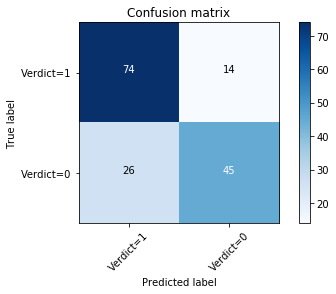

In [26]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Verdict=1','Verdict=0'],normalize= False,  title='Confusion matrix')

Verdict = 1 means "satisfactory" and Verdict = 0 means "not satisfactory"

Compute classification report including evaluation measures such as precision, recall and f1-score.

In [29]:
print (classification_report(y_test, yhat))

             precision    recall  f1-score   support

          0       0.76      0.63      0.69        71
          1       0.74      0.84      0.79        88

avg / total       0.75      0.75      0.74       159



Also compute the probability of a restaurant being "good enough" vs "not good enough" on the test set

In [30]:
yhat_prob = LR.predict_proba(X_test)

yhat_prob[0:30]

df = pd.DataFrame(yhat_prob,    # values
             )
df.columns = ["not satisfactory", "satisfactory"]

df

,not satisfactory,satisfactory
0,0.180976,0.819024
1,0.553629,0.446371
2,0.487636,0.512364
3,0.286802,0.713198
4,0.382519,0.617481
5,0.327545,0.672455
6,0.327545,0.672455
7,0.570597,0.429403
8,0.487636,0.512364
9,0.365666,0.634334


In [31]:
from sklearn.metrics import log_loss

logloss = log_loss(y_test, yhat_prob)

logloss

0.6002866019743978

## Discussion

We see that the model is fairly good at distinguishing "good enough" vs "not good enough" food places although we see that some decisions are very marginal. 

75% precision is a decent accuracy and shows that food type and priciness tends to capture a good proportion of the rating for a restaurant.

The model could be vastly more accurate with more data points for certain locations and taking into account other visible features such as menu, crowdedness, parking, bathroom etc.

Let's look at what type of resturant, in what price tier, and in which location we should build a restaurant, according to the model, to maximize the chance of being a "good enough" restaurant.

In [32]:
from itertools import product

venue_selections = []
for i in range(0,19):
    zeros = np.zeros((19,), dtype=int)
    zeros[i] = 1
    venue_selections.append(zeros)

price_tiers = range(1,5)

df_all_inputs = pd.DataFrame(columns = venue_categories)

for in_sthlm_city, price_tier, venue_selection in product([0,1], price_tiers, venue_selections):
            row = [in_sthlm_city]
            row.append(price_tier)
            row = row + venue_selection.tolist()
            df_all_inputs.loc[len(df_all_inputs)] = row

results = LR.predict_proba(df_all_inputs).tolist()

positive_probabilities = list(map(lambda x: x[1], results))

In [137]:
max_prob = max(positive_probabilities)    
index_max_positive_probabilities = [i for i, j in enumerate(probabilities) if j == max_prob]
print("Maximum probability for classification 'good enough' is: "  + str(max_prob))
print("Input for this classification is: ") 
df_all_inputs.iloc[index_max_positive_probabilities]

Maximum probability for classification 'good enough' is: 0.7947463154963378
Input for this classification is: 


,In Stockholm City,Price Tier,Restaurant,Asian Restaurant,Scandinavian Restaurant,Burger Joint,Fast Food Restaurant,Sushi Restaurant,Thai Restaurant,Pizza Place,...,Indian Restaurant,American Restaurant,Chinese Restaurant,Middle Eastern Restaurant,French Restaurant,Greek Restaurant,Japanese Restaurant,Steakhouse,Seafood Restaurant,Kebab Restaurant
135,1,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
min_prob = min(positive_probabilities)    
index_min_positive_probabilities = [i for i, j in enumerate(probabilities) if j == min_prob]
print("Minimum probability for classification 'good enough' is: "  + str(min_prob))
print("Input for this classification is: ") 
df_all_inputs.iloc[index_min_positive_probabilities]

Minimum probability for classification 'good enough' is: 0.5107216715988354
Input for this classification is: 


,In Stockholm City,Price Tier,Restaurant,Asian Restaurant,Scandinavian Restaurant,Burger Joint,Fast Food Restaurant,Sushi Restaurant,Thai Restaurant,Pizza Place,...,Indian Restaurant,American Restaurant,Chinese Restaurant,Middle Eastern Restaurant,French Restaurant,Greek Restaurant,Japanese Restaurant,Steakhouse,Seafood Restaurant,Kebab Restaurant
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The model tells us that an expensive Scandinavian Restaurant in Stockholm City has the maximum probability (~80%) of being a "good enough" restaurant according to customers.

The model also tells us that a cheap Fast Food Restaurant not in Stockholm City has the least probability (~50%) of being a "good enough" restaurant according to customers. 